In [54]:
import models
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import random
import patsy
from collections import defaultdict

In [55]:
random.seed(20211212)

# MODEL

In [56]:
data = pd.read_csv("explored-diabetes.csv")

## Null model

We first build a baseline null model using the target variable: `glyhb`. Recall from single variable exploratory analysis:

> The [glycosylated hemoglobin](https://en.wikipedia.org/wiki/Glycated_hemoglobin), a diagnostic test often referred to as simply a "hemoglobin A1c", is measured primarily to determine the three-month average blood sugar level.

The hemoglobin A1c works as a quasi-classification variable, with a diagnosis for the following ranges:

| A1c        | diagnosis   |
|------------|-------------|
| < 5.7%     | normal      | 
| 5.7 - 6.4% | prediabetic |
| > 6.4%     | diabetic    |

In [57]:
data["glyhb"].describe()

count    390.000000
mean       5.589769
std        2.242595
min        2.680000
25%        4.380000
50%        4.840000
75%        5.600000
max       16.110001
Name: glyhb, dtype: float64

Let's collect the null model's information: the mean and standard deviation or our target variable A1c.

In [58]:
null_mean = data["glyhb"].describe()["mean"]
null_mean

5.589769236246667

In [59]:
null_std = data["glyhb"].describe()["std"]
null_std

2.242594841991535

The mean for the target variable is 5.5898%, with a standard deviation or equivalent $\sigma$ of 2.2426%. Our goal is to improve upon this naive model using our linear regression model.

## Linear regression model

We begin first with the "all in" linear regression model. First, we'll have to rename a few columns due to specifics with our modeling library not accepting variables with periods.

In [60]:
data.rename(columns={"stab.glu": "stab_glu", "time.ppn": "time_ppn", "bp.s": "bp_s", "bp.d": "bp_d"}, inplace=True)

Next, we'll one-hot encode the `gender` and `frame` variables for potential use in our linear model.

In [61]:
data = data.join(pd.get_dummies(data["gender"]))
data = data.join(pd.get_dummies(data["frame"]))

Our "all in" linear regression model will consist of all available numeric (non-categorical) variables, exluding a few: `glyhb`, `eAG`, `female`, and `small`. The first two as they are either the target variable itself, or a analog of the target variable. The latter two are redundant variables --  a side effect of the one-hot encoding -- that are already expressed as the intercepts of the variables.

In [62]:
subset = data.select_dtypes(include="number").columns.drop(["glyhb", "female", "small", "eAG"])
model = f'glyhb ~ {" + ".join(subset)}'
result1 = models.bootstrap_linear_regression(model, data=data.dropna(subset=subset))
models.describe_bootstrap_lr(result1)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-8.40,-22.69,12.37
chol,$\beta_{1}$,0.00,-0.00,0.01
stab_glu,$\beta_{2}$,0.03,0.02,0.03
hdl,$\beta_{3}$,0.00,-0.03,0.02
ratio,$\beta_{4}$,0.12,-0.33,0.39
age,$\beta_{5}$,0.01,0.00,0.02
height,$\beta_{6}$,0.07,-0.14,0.23
weight,$\beta_{7}$,-0.01,-0.05,0.02
waist,$\beta_{8}$,-0.05,-0.44,0.28


We can learn a lot from the initial model -- first, the overall performance is fairly decent.

- Somewhat surprising, the model seems to have found a relationship between waist-to-hip ratio and A1c. This counters our exploratory data analysis, but falls inline with other diabetes prediction models.
- Stabilized glucose is a positive relationship -- as it increases, so does A1c (diabetes more likely). However, this relationship was strong, but due to the inconsistent scales, the "importance" of this variable may be understated in the model.
- BMI is supported in the data, but is victim to the same scale issue as stabilized glucose.
- There are several variables expressed multiple times, such as `hip` and `waist` being redundant with `waist_hip` there.
- Frame shows a relationship, but is inconsistent across the "large" and "medium" categories.

### Correlation coeffecients

Before we proceed, let's look at correlation coeffecients for each of our numeric variables:

In [63]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In [64]:
correlations(data.dropna(), "glyhb", data.select_dtypes(include="number").columns)

,feature,r,rho
0,chol,0.271652,0.225731
1,stab_glu,0.740905,0.519988
2,hdl,-0.169496,-0.210278
3,ratio,0.354653,0.309827
4,glyhb,1.000000,1.000000
5,age,0.332230,0.427119
6,height,0.052251,0.025864
7,weight,0.167769,0.222719
8,waist,0.247687,0.333495
9,hip,0.151673,0.234254


This confirms a lot of what we saw in our initial model. Stabilized glucose shows the strongest positive relationship -- nothing unexpected there. Cholesterol ratio shows the strongest relationship amonst the cholesterol-related variables. The waist-to-hip relationship is certainly present, most variables with relationships deomonstrating possibly non-linear relationship based on the Spearman's coeffecients.

Let's simplify our model using only variables with relationships to the target variable:

In [65]:
subset = ["stab_glu", "ratio", "waist_hip", "large", "medium", "bmi", "age"]
model = f'glyhb ~ {" + ".join(subset)}'
result2 = models.bootstrap_linear_regression(model, data=data.dropna(subset=subset))
models.describe_bootstrap_lr(result2)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,0.41,-0.93,2.39
stab_glu,$\beta_{1}$,0.03,0.02,0.03
ratio,$\beta_{2}$,0.15,-0.04,0.25
waist_hip,$\beta_{3}$,0.60,-2.04,2.38
large,$\beta_{4}$,-0.08,-0.52,0.32
medium,$\beta_{5}$,0.17,-0.17,0.55
bmi,$\beta_{6}$,0.01,-0.01,0.03
age,$\beta_{7}$,0.02,0.01,0.03
,,,,


### Domain knowledge numerical to categorical

Good, our $R^2$ and $\sigma$ are mantained despite the reduction in variables -- we'll keep things with fewer variables despite the slight error increase. Next, we'll use domain knowledge to bolster our model. Let's define one-hot encoded boolean variables discussed in exploratory data analysis: whether the individual is `obese`, whether the individual is `older`, and whether the individual has `hypertension`. We'll also attempt to use the stabilized glucose value as an indicator as to whether the indiviual is `diabetic`.

In [66]:
data["obese"] = (data["bmi"] > 30).astype(int, errors="ignore")
data["older"] = (data["age"] > 60).astype(int, errors="ignore")
data["hypertension"] = ((data["bp_s"] < 130) & (data["bp_d"] < 80)).astype(int, errors="ignore")
data["diabetic"] = (data["stab_glu"] > 130).astype(int, errors="ignore")

Let's add these to see if there is any effect on the overall performance of the linear model:

In [67]:
subset = ["stab_glu", "ratio", "waist_hip", "large", "medium", "bmi", "age", "obese", "older", "hypertension"]
model = f'glyhb ~ {" + ".join(subset)}'
result3 = models.bootstrap_linear_regression(model, data=data.dropna(subset=subset))
models.describe_bootstrap_lr(result3)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-0.06,-2.05,2.19
stab_glu,$\beta_{1}$,0.03,0.02,0.03
ratio,$\beta_{2}$,0.15,-0.01,0.28
waist_hip,$\beta_{3}$,0.63,-1.59,2.48
large,$\beta_{4}$,-0.09,-0.57,0.30
medium,$\beta_{5}$,0.17,-0.16,0.54
bmi,$\beta_{6}$,0.03,-0.01,0.06
age,$\beta_{7}$,0.02,-0.00,0.03
obese,$\beta_{8}$,-0.39,-0.74,0.01


Not enough of a difference to make it worth including them. Let's define our revised model for now:

In [68]:
subset = ["stab_glu", "ratio", "waist_hip", "large", "medium", "bmi", "age"]
model =f'glyhb ~ {" + ".join(subset)}'
result4 = models.bootstrap_linear_regression(model, data=data.dropna(subset=subset))
models.describe_bootstrap_lr(result4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,0.41,-1.18,2.24
stab_glu,$\beta_{1}$,0.03,0.02,0.03
ratio,$\beta_{2}$,0.15,-0.01,0.25
waist_hip,$\beta_{3}$,0.60,-1.15,2.66
large,$\beta_{4}$,-0.08,-0.61,0.42
medium,$\beta_{5}$,0.17,-0.20,0.52
bmi,$\beta_{6}$,0.01,-0.01,0.03
age,$\beta_{7}$,0.02,0.01,0.03
,,,,


### Residuals

Prior to finalizing the model, let's look at the residual error for the model. Together with domain knowledge, we can attempt to improve our model.

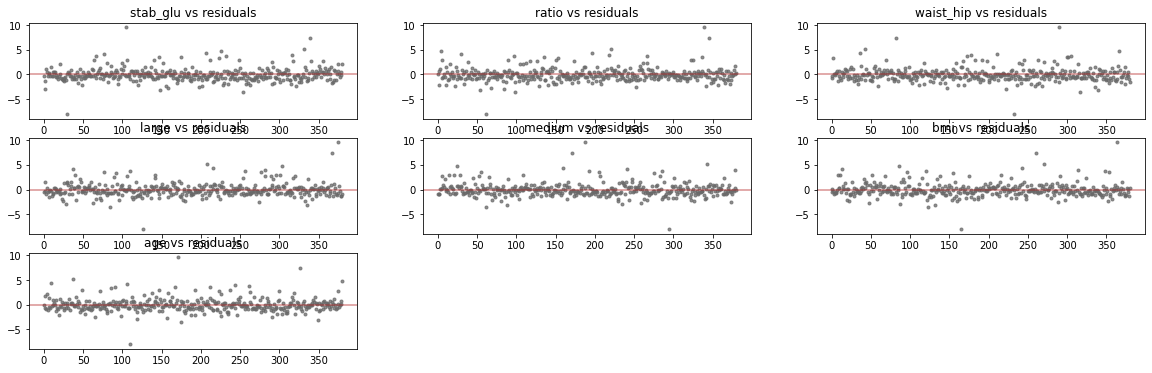

In [69]:
figure = plt.figure(figsize=(20,6))
variables = subset
plots = len(variables)
rows = (plots // 3) + 1

for i, variable in enumerate(variables): 
    axes = figure.add_subplot(rows, 3, i + 1)
    keyed_values = sorted( zip(data[variable].values, result4["residuals"]), key=lambda x: x[0])
    residuals = [x[1][0] for x in keyed_values]
    axes.plot(list(range(0, result4["n"])), residuals, ".", color="dimgray", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=result4["n"], c="firebrick", alpha=0.5)
    axes.set_title(variable + " vs residuals")

plt.show()
plt.close()

Wow -- these all look phenomenal. The residuals seem to indicate incredibly linear relationships across the board, thus no further transformation would be very beneficial. Just to make sure, let's check a little closer at each of the residuals, as the outliers may be disguising the errors.

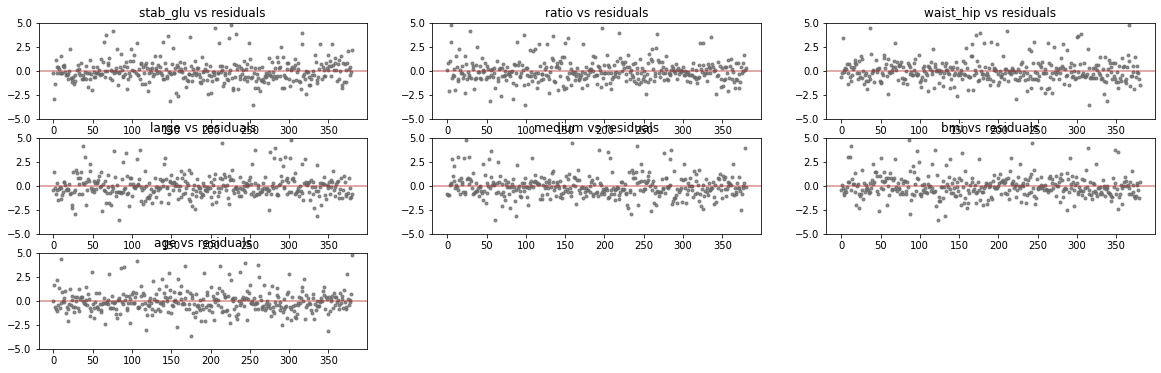

In [70]:
figure = plt.figure(figsize=(20,6))
variables = subset
plots = len(variables)
rows = (plots // 3) + 1

for i, variable in enumerate(variables): 
    axes = figure.add_subplot(rows, 3, i + 1)
    keyed_values = sorted( zip(data[variable].values, result4["residuals"]), key=lambda x: x[0])
    residuals = [x[1][0] for x in keyed_values]
    axes.plot(list(range(0, result4["n"])), residuals, ".", color="dimgray", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=result4["n"], c="firebrick", alpha=0.5)
    axes.set_title(variable + " vs residuals")
    axes.set_ylim((-5,5))

plt.show()
plt.close()

The overall conclusion remains the same -- all of the residuals do not exhibit skews or worrisome patterns.

### Interaction terms / transformations

Next, we'll take a look at some possible transformations to further improve our model. First, during exploratory data analysis, we noticed the higher stabilized glucose values above 100 mg/dL were critical to the relationship between the variable and A1c. Let's create a categorical variable to help extract that importance of the higher stabilized glucose values. We'll do this by "predicting" diabetes by transforming the normal, prediabetic, and diabetic ranges of A1c reading to a scale that is similar to stabilized glucose: estimated average glucose.

In [71]:
def A1c_to_eAG(A1c):
    return 28.7 * A1c - 46.7

In [72]:
data["numeric_diagnosis"] = pd.cut(data["stab_glu"], [0, A1c_to_eAG(5.7), A1c_to_eAG(6.4), np.inf], labels=[1, 2, 3]).astype(int)

Let's use this numeric diagnosis as an interaction term with the stabilized glucose to emphasize the importance of higher stabilized glucose values.

In [73]:
subset = ["stab_glu", "ratio", "waist_hip", "large", "medium", "bmi", "age", "numeric_diagnosis"]
model = f'glyhb ~ {" + ".join(subset)}'
result5 = models.bootstrap_linear_regression(model, data=data.dropna(subset=subset))
models.describe_bootstrap_lr(result5)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,0.33,-0.91,1.70
stab_glu,$\beta_{1}$,0.02,0.01,0.03
ratio,$\beta_{2}$,0.13,-0.03,0.25
waist_hip,$\beta_{3}$,0.73,-1.09,2.38
large,$\beta_{4}$,-0.12,-0.51,0.23
medium,$\beta_{5}$,0.16,-0.13,0.50
bmi,$\beta_{6}$,0.01,-0.01,0.03
age,$\beta_{7}$,0.02,0.01,0.03
numeric_diagnosis,$\beta_{8}$,0.64,0.09,1.22


No noticeable improvement, perhaps we could adjust the data to align with a natural baseline such as the average glucose reading for a normal indvidual: 100 mg/dL. This way, we can interpret the variable as a certain number *above* the normal baseline glucose reading.

In [74]:
data["stab_glu_100"] = data["stab_glu"] - 100

In [75]:
subset = ["stab_glu_100", "ratio", "waist_hip", "large", "medium", "bmi", "age"]
model = f'glyhb ~ {" + ".join(subset)}'
result6 = models.bootstrap_linear_regression(model, data=data.dropna(subset=subset))
models.describe_bootstrap_lr(result6)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,3.17,1.64,5.05
stab_glu_100,$\beta_{1}$,0.03,0.02,0.03
ratio,$\beta_{2}$,0.15,-0.03,0.27
waist_hip,$\beta_{3}$,0.60,-1.14,2.33
large,$\beta_{4}$,-0.08,-0.43,0.40
medium,$\beta_{5}$,0.17,-0.15,0.49
bmi,$\beta_{6}$,0.01,-0.01,0.02
age,$\beta_{7}$,0.02,0.01,0.03
,,,,


Certainly didn't improve our model. Looks like our model is very stubbornly remaining at a $R^2$ value of around 60%. Let's finalize our model and move on to evaluation and comparison to the null model.

In [76]:
final_model = "glyhb ~ stab_glu + ratio + waist_hip + large + bmi + age"
final = models.bootstrap_linear_regression(final_model, data.dropna(subset=["stab_glu", "ratio", "waist_hip", "large", "bmi", "age"]))
models.describe_bootstrap_lr(final)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,0.34,-1.40,1.76
stab_glu,$\beta_{1}$,0.03,0.02,0.03
ratio,$\beta_{2}$,0.16,0.01,0.27
waist_hip,$\beta_{3}$,0.68,-1.26,2.40
large,$\beta_{4}$,-0.20,-0.55,0.12
bmi,$\beta_{5}$,0.01,-0.01,0.03
age,$\beta_{6}$,0.02,0.01,0.03
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,


*Prior to moving on, let's quickly attempt a log transormation on the `glyhb` variable. Since it is bounded by 0, it may be worthwhile to attempt.*

In [77]:
data["log_glyhb"] = np.log(data["glyhb"])

log_model = "log_glyhb ~ stab_glu + ratio + waist_hip + large + bmi + age"
log_result = models.bootstrap_linear_regression(log_model, data=data.dropna(subset=["stab_glu", "ratio", "waist_hip", "large", "bmi", "age"]))
models.describe_bootstrap_lr(log_result)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,0.83,0.56,1.05
stab_glu,$\beta_{1}$,0.00,0.00,0.00
ratio,$\beta_{2}$,0.02,0.00,0.04
waist_hip,$\beta_{3}$,0.14,-0.16,0.40
large,$\beta_{4}$,-0.01,-0.07,0.02
bmi,$\beta_{5}$,0.00,-0.00,0.01
age,$\beta_{6}$,0.00,0.00,0.00
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,


Nope! We carry on.

## Evaluation / comparison

### Cross validation

We evaluate our linear regression model with five rounds of 10-fold cross validation. We'll use $sigma$ and $R^2$ to evaluate the model.

In [78]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

In [79]:
def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=5):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

In [80]:
cv_result = cross_validation(models.linear_regression, final_model, data.dropna(subset=["stab_glu", "ratio", "waist_hip", "large", "bmi", "age"]), lambda r: (r["sigma"], r["r_squared"]))

Let's look at the $\sigma$ and $R^2$ results and produce a 95% credible interval for our now 50 estimates of the metrics. 

In [81]:
sigmas = [r[0] for r in cv_result]
r_2s = [r[1] for r in cv_result]

In [82]:
print("95% CI for σ:", stats.mstats.mquantiles(sigmas, [0.025, 0.975]))

95% CI for σ: [0.89364766 2.45209037]


In [83]:
print("95% CI for R²:", stats.mstats.mquantiles(r_2s, [0.025, 0.975]))

95% CI for R²: [0.13383329 0.82104031]


These are decent. Not fantastic. But not terrible. Let's look at another interpretation from the results, where we look at the bootstrapped mean for $\sigma$ and $R^2$. In essence we are estimating the average performance for our linear regression model that estimates A1c.

In [84]:
def resample(data):
    n = len(data)
    return [data[ i] for i in [stats.randint.rvs(0, n - 1) for _ in range( 0, n)]]

In [85]:
bootstrap = {}
bootstrap["sigma"] = np.array([np.mean(s) for s in [resample(sigmas) for i in range( 0, 1000)]])
bootstrap["r_squared"] = np.array([np.mean(r) for r in [resample(r_2s) for i in range( 0, 1000)]])

In [86]:
print(r"95% CI for *mean* sigma:", stats.mstats.mquantiles(bootstrap["sigma"], [0.025, 0.975]))

95% CI for *mean* sigma: [1.38789208 1.62488988]


In [87]:
print(r"95% CI for *mean* R^2:", stats.mstats.mquantiles(bootstrap["r_squared"], [0.025, 0.975]))

95% CI for *mean* R^2: [0.50708137 0.60055963]


These results are actually quite decent. Recall our null model's standard deviation (that can be compared to our $\sigma$):

In [88]:
null_std

2.242594841991535

Whereas our 95% confidence interval for the mean is relatively tight from 1.1488 to 1.6148% -- a marked improvement over the null model.

### Learning curves

A potential downside of our selected dataset is the relatively small number of data points. During our learning curve simulation, we plot more and more subsets of our test data to indicate whether we are in a high bias or high variance situation.

In [89]:
def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

In [90]:
def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)

                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results

In [91]:
lc_results = learning_curves(models.linear_regression, model, data.dropna(subset=["stab_glu", "ratio", "waist_hip", "large", "bmi", "age"]), lambda r: r["sigma"])

/Users/gagebenne/Projects/data-science/diabetes-data-analysis/models.py:42: RuntimeWarning: invalid value encountered in sqrt
  result["sigma"] = np.sqrt( sum_squared_error / (n - k))
/Users/gagebenne/Projects/data-science/diabetes-data-analysis/models.py:42: RuntimeWarning: invalid value encountered in sqrt
  result["sigma"] = np.sqrt( sum_squared_error / (n - k))
/Users/gagebenne/Projects/data-science/diabetes-data-analysis/models.py:42: RuntimeWarning: invalid value encountered in sqrt
  result["sigma"] = np.sqrt( sum_squared_error / (n - k))
/Users/gagebenne/Projects/data-science/diabetes-data-analysis/models.py:42: RuntimeWarning: invalid value encountered in sqrt
  result["sigma"] = np.sqrt( sum_squared_error / (n - k))
/Users/gagebenne/Projects/data-science/diabetes-data-analysis/models.py:42: RuntimeWarning: invalid value encountered in sqrt
  result["sigma"] = np.sqrt( sum_squared_error / (n - k))
/Users/gagebenne/Projects/data-science/diabetes-data-analysis/models.py:42: Runt

In [92]:
def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

In [93]:
def plot_learning_curves( results, metric, desired=None, zoom=False, credible=True):
    figure = plt.figure(figsize=(10,6))
    axes = figure.add_subplot(1, 1, 1)
    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)
    axes.plot( xs, train_mean, color="steelblue", label="train")
    axes.plot( xs, test_mean, color="firebrick", label="test")
    if credible:
        axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25)
        axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25)
    if desired:
        if type(desired) is tuple:
            axes.axhline((desired[0] + desired[1])/2.0, color="gold", label="desired")
            axes.fill_between( xs, desired[1], desired[0], color="gold", alpha=0.25)
        else:
            axes.axhline( desired, color="gold", label="desired")
    axes.legend()
    axes.set_xlabel("training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")
    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))
    plt.show()
    plt.close()

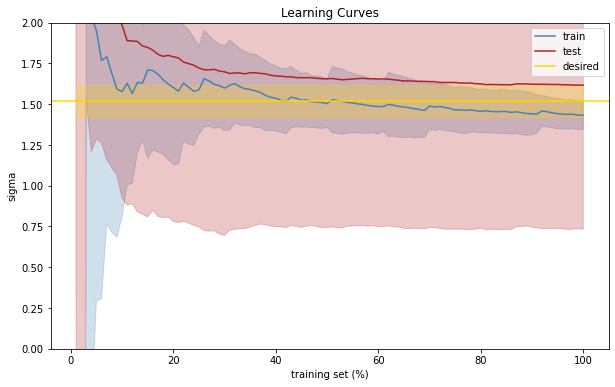

In [94]:
plot_learning_curves(lc_results, "sigma", zoom=True, desired=(1.41875477, 1.6147503))

Somewhat surprisingly, the curves converge appropriately. This would imply that gathering more data wouldn't really benefit this model much. The $\sigma$ isn't fantastic, but it is an improvement from our null model, and an improvement from a model that simply involves the stabilized glucose -- the strongest indicator of a higher A1c.

### Predictions

Let's do some predictions! A reminder of our final model:

In [95]:
final_model

'glyhb ~ stab_glu + ratio + waist_hip + large + bmi + age'

Let's begin with an individual who is the picture of health despite being over 70. 75 mm/dL stabilized glucose, with a BMI of 20 (ideal BMI for most adults), and a cholesterol ratio of 3.5 (again, ideal for most adults).

In [96]:
individual1 = [[
    1, # intercept
    75, # stabilized glucose
    3.5, # ratio
    .95, # waist-to-hip
    0, # large
    20, # BMI
    75 # age
]]

prediction = final["model"].predict(individual1)
prediction[0][0]


5.0152358331625795

5.08% for an A1c seems fairly reasonable. Certainly we do not expect the individual to have diabetes, and with the boundary at 6.4%+ this individual wouldn't be diagnosed with diabetes or pre-diabetes. Even testing the model with an older individual to trip it up didn't work, despite age being somewhat of a predictor for diabetes -- other factors are more important to the prediction.

In [97]:
prediction[0][0] - 1.96 * final["sigma"], prediction[0][0] + 1.96 * final["sigma"]

(2.2032985540500034, 7.8271731122751556)

Our 95% confidence interval for the prediction isn't very helpful to us as it includes ranges for diabetics and non-diabetics alike.

Let's try one more prediction with an individual who might be considered "at-risk" given their medical status. And individual who is obese with a BMI of 34, as well as has a high stabilized glucose and higher cholesterol ratio than is ideal.

In [98]:
individual2 = [[
    1, # intercept
    200, # stabilized glucose
    4.5, # ratio
    1.25, # waist-to-hip
    1, # large
    34, # BMI
    45 # age
]]

prediction = final["model"].predict(individual2)
prediction[0][0]

8.237367190191486

8.26%! Well above the threshold to be considered diabetic. Interestingly, the stabilized glucose wasn't particularly high, so we get the sense that the model is also capable of picking out important indicators in variables outside of stabilized glucose.

As a quick aside, let's run through each of the individuals in the dataset (or atleast those without missing values where we need them), and see if our model would've given the correct classification of diabetic or not. For this example we will consider those who are pre-diabetic as diabetic. Pre-diabetes somewhat of a misnomer. It doesn't indicate that you are on the "verge" of getting diabetes, it simply indicates your A1c reading is borderline. Erring on the cautious side, we'd rather our model predict an individual has diabetes than not.

In [99]:
null_accuracy = 0
model_accuracy = 0
for _, row in data.dropna(subset=["stab_glu", "ratio", "waist_hip", "large", "bmi", "age"]).iterrows():
    individual = [[
        1, # intercept
        row["stab_glu"], # stabilized glucose
        row["ratio"], # ratio
        row["waist_hip"], # waist_hip
        row["large"], # large
        row["bmi"], # BMI
        row["age"] # age
    ]]
    prediction = (final["model"].predict(individual)[0][0] > 5.7)
    actual = (row["glyhb"] > 5.7)
    if prediction == False: # glyhb mean > 5.7
        null_accuracy += 1
    if prediction == actual:
        model_accuracy += 1

In [100]:
null_accuracy / len(data.dropna(subset=["stab_glu", "ratio", "waist_hip", "large", "bmi", "age"]))

0.7270341207349081

So, for our null predictor (where every prediction was false -- most individuals do not have diabetes) our model correctly predicted the datasets diagnosis 70.87% of the time.

In [101]:
model_accuracy / len(data.dropna(subset=["stab_glu", "ratio", "waist_hip", "large", "bmi", "age"]))

0.8503937007874016

On the other side, our linear regression model accurately predicted a diagnosis 84.78% of the time. A marked improvement over the null model.

In [102]:
model_accuracy = 0
for _, row in data.dropna(subset=["stab_glu", "ratio", "waist_hip", "large", "bmi", "age"]).iterrows():
    individual = [[
        1, # intercept
        row["stab_glu"], # stabilized glucose
        row["ratio"], # ratio
        row["waist_hip"], # waist_hip
        row["large"], # large
        row["bmi"], # BMI
        row["age"] # age
    ]]
    prediction = (final["model"].predict(individual)[0][0] > 6.4)
    actual = (row["glyhb"] > 6.4)
    if prediction == actual:
        model_accuracy += 1

In [103]:
model_accuracy / len(data.dropna(subset=["stab_glu", "ratio", "waist_hip", "large", "bmi", "age"]))

0.9028871391076115

If we consider only a prediction of diabetes (that is -- not including those who are pre-diabetic), our model is able to accurate predict the diagnosis of 90.03% of the individuals in our dataset.